[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Danysan1/ai-unibo-nlp-project/blob/main/final/final.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/Danysan1/ai-unibo-nlp-project/blob/main/final/final.ipynb)
[![Open in SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/Danysan1/ai-unibo-nlp-project/tree/main/final/final.ipynb)

# Final project

## Imports and Initial Settings

In [1]:
%pip install pandas numpy matplotlib transformers==4.25.1  dataset

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
from os import path
from matplotlib import pyplot as plt
import random
import gc
import torch
import transformers
from tqdm import tqdm
from typing import Callable, Dict, List, Tuple
from timeit import default_timer as timer
from transformers import EncoderDecoderModel, AutoTokenizer, PreTrainedTokenizer, BatchEncoding
from torch.utils.data import Dataset, DataLoader

2023-04-16 16:24:34.841504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 16:24:35.016567: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-16 16:24:35.697627: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /lib/:/home/hiari/opt/mambaforge/lib:/home/hiari/opt/mambaforge/envs/ai/lib/:/home/hiar

In [3]:
# Fix the random state to 42
SEED = 42
labels = ['Self-direction: thought', 'Self-direction: action', 'Stimulation',
       'Hedonism', 'Achievement', 'Power: dominance', 'Power: resources',
       'Face', 'Security: personal', 'Security: societal', 'Tradition',
       'Conformity: rules', 'Conformity: interpersonal', 'Humility',
       'Benevolence: caring', 'Benevolence: dependability',
       'Universalism: concern', 'Universalism: nature',
       'Universalism: tolerance', 'Universalism: objectivity']

# if a different set of labels is needed, decomment the next lines and select a different subset of labels,
# but always use the variable 'labels' since all the code will use that. If you want to select
# the full set of labels, just comment the next two lines

#suggested_labels = ['Self-direction: action', 'Achievement', 'Security: personal', 'Security: societal', 'Benevolence: caring', 'Universalism: concern']
#labels = suggested_labels

In [4]:
def fix_seed(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_seed(SEED)

## Dataset Download

In [5]:
import os
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.tsv')
    if not os.path.exists(data_path):
        print(f"Downloading Touché23-ValueEval {suffix} data... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [6]:
data_folder = 'Dataset'

In [7]:
# Training data
training = {'suffix': 'arguments-training', 'url': "https://zenodo.org/record/7550385/files/arguments-training.tsv?download=1"}
labels_training = {'suffix': 'labels-training', 'url': "https://zenodo.org/record/7550385/files/labels-training.tsv?download=1"}
level1_labels_training = {'suffix': 'level1-labels-training', 'url': "https://zenodo.org/record/7550385/files/level1-labels-training.tsv?download=1"}

# Validation data
validation = {'suffix': 'arguments-validation', 'url': "https://zenodo.org/record/7550385/files/arguments-validation.tsv?download=1"}
labels_validation = {'suffix': 'labels-validation', 'url': "https://zenodo.org/record/7550385/files/labels-validation.tsv?download=1"}
level1_labels_validation = {'suffix': 'level1-labels-validation', 'url': "https://zenodo.org/record/7550385/files/level1-labels-validation.tsv?download=1"}

# Test data
test = {'suffix': 'arguments-test', 'url': "https://zenodo.org/record/7550385/files/arguments-test.tsv?download=1"}

to_download = [training, 
                labels_training,
                validation,
                labels_validation]

In [8]:
for data in to_download:
    download_data(data_path=data_folder, url_path=data['url'], suffix=data['suffix'])

## Dataset Loading

In [9]:
def load_touche_dataset(filename:str) -> pd.DataFrame:
    with open(path.join(data_folder, filename)) as file_obj:
        data = pd.read_csv(path.join(data_folder, filename), sep='\t', header=0, index_col='Argument ID')
        return data

In [10]:
def filter_labels(labels_df:pd.DataFrame, subset:pd.Series) -> pd.DataFrame:
    """
        Given a DataFrame of labels (e.g. from labels-training.tsv), this method drops all the columns not contained in the subset list 
    """
    m = labels_df[subset].mask(labels_df[subset] == 0).dropna(how='all').replace(np.NaN, 0)
    return pd.DataFrame(m, dtype=int)

def filter_indexes(data_df:pd.DataFrame, subset:pd.Series) -> pd.DataFrame:
    """
        Given a DataFrame of arguments (e.g. from arguments-training.tsv), this method drops all the rows with indexes not contained in the subset list.
        This method is useful after a labels DataFrame has been filtered, because it removes rows that couldn't be classificated
    """
    return data_df.filter(subset, axis='index')

In [11]:
train_labels_df = filter_labels(load_touche_dataset("labels-training.tsv"), subset=labels)
train_df = filter_indexes(load_touche_dataset("arguments-training.tsv"), subset=train_labels_df.index) 
val_labels_df = filter_labels(load_touche_dataset("labels-validation.tsv"), subset=labels)
val_df = filter_indexes(load_touche_dataset("arguments-validation.tsv"), subset=val_labels_df.index)
train_df.head() 

,Conclusion,Stance,Premise
Argument ID,,,
A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...
A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...
A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...
A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...
A01008,We should ban factory farming,against,factory farming allows for the production of c...


In [12]:
val_df.head()

,Conclusion,Stance,Premise
Argument ID,,,
A01001,Entrapment should be legalized,in favor of,if entrapment can serve to more easily capture...
A01012,The use of public defenders should be mandatory,in favor of,the use of public defenders should be mandator...
A02001,Payday loans should be banned,in favor of,payday loans create a more impoverished societ...
A02002,Surrogacy should be banned,against,Surrogacy should not be banned as it is the wo...
A02009,Entrapment should be legalized,against,entrapment is gravely immoral and against huma...


In [13]:
train_labels_df.head()

,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
Argument ID,,,,,,,,,,,,,,,,,,,,
A01002,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
A01005,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
A01006,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
A01007,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
A01008,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0


In [14]:
train_df.describe().drop(index=['top'], axis=1)

,Conclusion,Stance,Premise
count,5392,5392,5392
unique,332,2,5312
freq,114,2898,2


A barplot to describe the representation in the dataset of each argument's category

<BarContainer object of 20 artists>

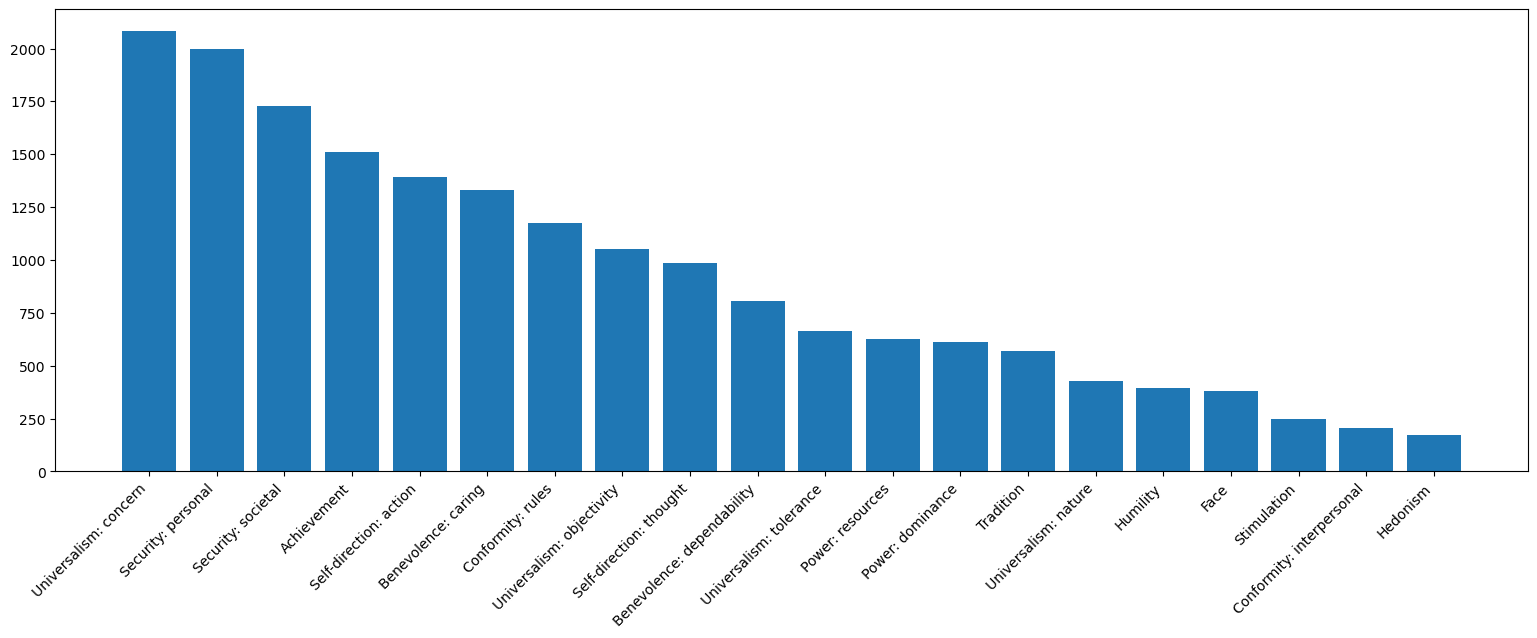

In [15]:
values = train_labels_df.sum().sort_values(ascending=False)
y = np.array(values)
x = np.array(values.index)

plt.figure(figsize=(19,6))
plt.xticks(rotation=45, ha="right")
plt.bar(x, height=y)

In [16]:
labels_names = train_labels_df.columns.tolist()
labels_names

['Self-direction: thought',
 'Self-direction: action',
 'Stimulation',
 'Hedonism',
 'Achievement',
 'Power: dominance',
 'Power: resources',
 'Face',
 'Security: personal',
 'Security: societal',
 'Tradition',
 'Conformity: rules',
 'Conformity: interpersonal',
 'Humility',
 'Benevolence: caring',
 'Benevolence: dependability',
 'Universalism: concern',
 'Universalism: nature',
 'Universalism: tolerance',
 'Universalism: objectivity']

In [17]:
train_labels_df.values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0]])

## Baseline model

In [18]:
from sklearn.metrics import f1_score
dummy_predictions = np.ones(val_labels_df.shape)
micro = f1_score(val_labels_df.values, dummy_predictions, average='micro')
macro = f1_score(val_labels_df.values, dummy_predictions, average='macro')
print("Baseline F1 score: micro=", micro, " macro=", macro)

Baseline F1 score: micro= 0.28722419205492444  macro= 0.27177163823134165


## Bi-gram model

In [19]:
train_df.columns
train_df_merged = pd.DataFrame(train_df.apply(lambda x: ','.join(x.dropna().astype(str)), axis=1),
                            columns=["Text"], index=None)
val_df_merged = pd.DataFrame(val_df.apply(lambda x: ','.join(x.dropna().astype(str)), axis=1),
    columns=["Text"], index=None)

In [20]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

def make_dataset(dataframe, labels):
    ds =  tf.data.Dataset.from_tensor_slices(
        (dataframe["Text"].values, labels.values)
    )
    return ds.batch(batch_size=32)

In [21]:
split = 3500
train_ds = make_dataset(train_df_merged.iloc[:split], train_labels_df[:split])
val_ds = make_dataset(train_df_merged.iloc[split:],train_labels_df[split:] )
test_ds = make_dataset(val_df_merged, val_labels_df)

2023-04-16 16:24:37.668982: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-16 16:24:37.687359: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-16 16:24:37.687557: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-16 16:24:37.689354: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

In [22]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 20), dtype=tf.int64, name=None))>

In [23]:
vocabulary = set()
train_df_merged["Text"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

12740


In [73]:
from tensorflow.keras.layers import TextVectorization

text_vectorization = TextVectorization(max_tokens = vocabulary_size,
                                       output_mode = "tf_idf",
                                       ngrams=3
                                       )

text_vectorization.adapt(train_ds.map(lambda x,y: x))
bigram_train_ds = train_ds.map(lambda x,y : (text_vectorization(x),y), num_parallel_calls=tf.data.AUTOTUNE)
bigram_val_ds = val_ds.map(lambda x,y : (text_vectorization(x),y), num_parallel_calls=tf.data.AUTOTUNE)
bigram_test_ds = test_ds.map(lambda x,y : (text_vectorization(x),y), num_parallel_calls=tf.data.AUTOTUNE)

In [74]:
from keras.optimizers import Adam

def get_model(max_tokens = vocabulary_size, hidden_dim=32):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation = "relu")(inputs)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(len(labels_names), activation = "sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=Adam(),
                  loss ="binary_crossentropy",
                  metrics=["accuracy"])
    return model

def get_model2(max_tokens = vocabulary_size):
    model = keras.Sequential([
        keras.Input(shape=(max_tokens,)),
        layers.Dense(512, activation ="relu"),
        layers.Dense(256, activation ="relu"),
        layers.Dense(len(labels_names), activation ="sigmoid"),

    ])
    model.compile(optimizer=Adam(),
                  loss ="binary_crossentropy",
                  metrics=["accuracy"])
    return model

In [75]:
model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_2gram.keras", save_best_only=True)
]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12740)]           0         
                                                                 
 dense_4 (Dense)             (None, 32)                407712    
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 20)                660       
                                                                 
Total params: 408,372
Trainable params: 408,372
Non-trainable params: 0
_________________________________________________________________


In [76]:
model.fit(bigram_train_ds,
          validation_data = bigram_val_ds,
          epochs=10,
          callbacks=callbacks)

Epoch 1/10
110/110 [==============================] - 1s 3ms/step - loss: 0.5012 - accuracy: 0.1266 - val_loss: 0.4559 - val_accuracy: 0.1797
Epoch 2/10
110/110 [==============================] - 0s 2ms/step - loss: 0.3482 - accuracy: 0.2560 - val_loss: 0.4270 - val_accuracy: 0.2193
Epoch 3/10
110/110 [==============================] - 0s 2ms/step - loss: 0.2870 - accuracy: 0.2963 - val_loss: 0.4494 - val_accuracy: 0.2172
Epoch 4/10
110/110 [==============================] - 0s 2ms/step - loss: 0.2478 - accuracy: 0.3240 - val_loss: 0.4624 - val_accuracy: 0.2119
Epoch 5/10
110/110 [==============================] - 0s 2ms/step - loss: 0.2164 - accuracy: 0.3283 - val_loss: 0.4762 - val_accuracy: 0.2178
Epoch 6/10
110/110 [==============================] - 0s 2ms/step - loss: 0.1909 - accuracy: 0.3374 - val_loss: 0.5080 - val_accuracy: 0.2109
Epoch 7/10
110/110 [==============================] - 0s 2ms/step - loss: 0.1756 - accuracy: 0.3340 - val_loss: 0.5411 - val_accuracy: 0.2273
Epoch 

In [77]:
model = keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model.evaluate(bigram_test_ds)[1]}")

60/60 [==============================] - 0s 1ms/step - loss: 0.4442 - accuracy: 0.1841
Test acc: 0.18407173454761505


In [78]:
model.evaluate(bigram_test_ds)

60/60 [==============================] - 0s 1ms/step - loss: 0.4442 - accuracy: 0.1841


[0.4442370533943176, 0.18407173454761505]

In [79]:
y_p = model.predict(bigram_test_ds)

60/60 [==============================] - 0s 879us/step


In [80]:
y_p[0]

array([0.1520402 , 0.35189086, 0.02381035, 0.02225954, 0.33870485,
       0.04731569, 0.11031144, 0.0261517 , 0.32028434, 0.44067907,
       0.06113632, 0.20967825, 0.03823125, 0.07780516, 0.18381433,
       0.18585955, 0.31532165, 0.08411199, 0.18899667, 0.23731965],
      dtype=float32)

In [87]:
threshold = 0.25
y_pred=[]
for sample in y_p:
  y_pred.append([1 if i>=threshold else 0 for i in sample])
y_pred = np.array(y_pred)
y_pred.shape

(1896, 20)

In [88]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(val_labels_df.values, y_pred)
print(classification_report(val_labels_df.values, y_pred, target_names = labels_names, zero_division = 0))

                            precision    recall  f1-score   support

   Self-direction: thought       0.40      0.20      0.26       251
    Self-direction: action       0.32      0.68      0.43       496
               Stimulation       1.00      0.01      0.01       138
                  Hedonism       0.00      0.00      0.00       103
               Achievement       0.32      0.86      0.47       575
          Power: dominance       0.00      0.00      0.00       164
          Power: resources       0.10      0.02      0.03       132
                      Face       0.50      0.01      0.02       130
        Security: personal       0.41      0.97      0.58       759
        Security: societal       0.27      0.95      0.42       488
                 Tradition       0.03      0.01      0.01       172
         Conformity: rules       0.34      0.50      0.40       455
 Conformity: interpersonal       0.00      0.00      0.00        60
                  Humility       0.01      0.01